In [1]:
#The script is for the antigen activated B explore of the remapped data
import scanpy as sc #for scanpy >= 1.3.7
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import logging
import os
import glob
import matplotlib
import math

In [2]:
def pca_elbow(adata, n_genes, n_pca_pcs, name):
    rcParams['figure.figsize']=(8,8)
    rcParams['font.size']=16
    
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=n_genes)
    sc.pp.pca(adata, n_comps=n_pca_pcs, use_highly_variable=True, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=False, save = '_{}.png'.format(name))
    
def removegenes(adata):
    """remove human HLA genes from the dataset 
    Parameters:
    ----------
    adata: scanpy.adata
        scanpy adata object

    Returns:
    -------
    temp: scanpy.adata
        scanpy adata object
    """
    IGKV = [x for x in adata.var_names if x.startswith('IGKV')]
    IGHV = [x for x in adata.var_names if x.startswith('IGHV')]
    IGLV = [x for x in adata.var_names if x.startswith('IGLV')]
    IGLC = [x for x in adata.var_names if x.startswith('IGLC')]
    IGLL = [x for x in adata.var_names if x.startswith('IGLL')]
    IGKC = [x for x in adata.var_names if x.startswith('IGKC')]
    IGHC = [x for x in adata.var_names if x.startswith('IGHC')]
    TRAV = [x for x in adata.var_names if x.startswith('TRAV')]
    TRBV = [x for x in adata.var_names if x.startswith('TRBV')]
    
    exclude = IGKV + IGHV + IGLV + IGKC + IGHC + IGLL + IGLC+TRAV + TRBV 
    gene = [x for x in adata.var_names if x not in exclude]
    temp = adata[:,gene].copy()
    return(temp)
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


def sil_cal(adata, res_list, n_knn_pcs):
    key_list = []
    for res in res_list:
        key_list.append('res_{}'.format(res))
        sc.tl.leiden(adata, resolution=res, key_added = 'res_{}'.format(res))
        
    pca_matrix = adata.obsm['X_pca'][:,0:n_knn_pcs]
    sil_df = pd.DataFrame(index = adata.obs.index, columns = key_list)
    info_df = pd.DataFrame(index = key_list, columns = ['n_clusters', 'sil_avg', 'res'])
    
    info_df['res'] = res_list
    
    for res_name in key_list:
        
        labels = adata.obs[res_name].to_numpy(dtype = int)
        n_clusters = len(adata.obs[res_name].unique())
        
        info_df.loc[res_name, 'n_clusters'] = n_clusters
        
        if labels.sum() == 0:
            print('At resolution {} only 1 cluster is defined, skip to the next resolution'.format(res_name.split('_')[1]))
            sil_df[res_name] = 0
            info_df.loc[res_name, 'sil_avg'] = 0
            continue
        else:
            silhouette_avg = silhouette_score(pca_matrix, adata.obs[res_name].to_numpy(dtype = int))
            sample_silhouette_values = silhouette_samples(pca_matrix, adata.obs[res_name].to_numpy(dtype = int))
            sil_df[res_name] = sample_silhouette_values
            info_df.loc[res_name, 'sil_avg'] = silhouette_avg
            print('At resolution {} the average silhouette score is {}'.format(res_name.split('_')[1], silhouette_avg))
            
    return(sil_df, info_df)

def summary_plot(info_df, path, name):
    temp_df = info_df.loc[info_df.sil_avg != 0]
    
    rcParams['figure.figsize']=(20,10)
    rcParams['font.size']=22
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sb.scatterplot(data = temp_df, x = 'res', y = 'sil_avg',s =200, 
                   alpha = 0.5, color = 'black', edgecolor = 'k', ax = ax1)
    sb.scatterplot(data = temp_df, x = 'n_clusters', y = 'sil_avg',s =200, alpha = 0.5, 
                   color = 'black', edgecolor = 'k', ax = ax2)
    
    ax1.set_xlabel("Resolution")
    ax1.set_ylabel("Average silhouette score")
    ax2.set_xlabel("Cluster numbers")
    ax2.set_ylabel("Average silhouette score")

    save_dir = os.path.join(path, name)
    fig.savefig(save_dir, bbox_inches='tight')
#   plt.close()

In [3]:
path = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/processed_data/pp_2.h5ad'
adata_raw = sc.read_h5ad(path)
savepath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/processed_data/B_cells.h5ad'
adata_B = sc.read_h5ad(savepath)

In [4]:
ind_as_B = adata_B.obs.loc[adata_B.obs.subtype == 'Antigen stimulated B'].index
adata_asB = adata_raw[ind_as_B, :].copy()
adata_asB = removegenes(adata_asB)

In [5]:
adata_asB.obs.loc[ind_as_B, ['tissue', 'disease_stage', 
                                'gender', 'patient_ID']] = adata_B.obs.loc[ind_as_B, ['tissue', 'disease_stage', 
                                'gender', 'patient_ID']]

In [6]:
sc.pp.filter_genes(adata_asB,min_cells=3)

In [7]:
adata_asB

AnnData object with n_obs × n_vars = 2472 × 13592
    obs: 'sample_id', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'pct_counts_mt', 'cell_quality', 'tissue', 'disease_stage', 'gender', 'patient_ID'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [8]:
#normalize the data
sc.pp.normalize_total(adata_asB, target_sum=1e4)
sc.pp.log1p(adata_asB)

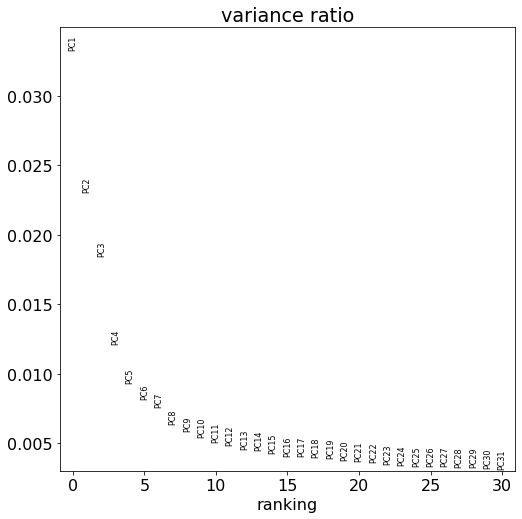

In [9]:
sc.settings.figdir = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/B_cells/asB/'
pca_elbow(adata_asB, 2000, 50, 'asB')

In [10]:
adata_asB.obs.groupby('tissue').size()

tissue
Blood     141
Liver    2331
dtype: int64

In [13]:
sc.external.pp.bbknn(adata_asB, batch_key='tissue', neighbors_within_batch=10, n_pcs=10)

In [14]:
res_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.5]
temp_adata = adata_asB.copy()
test_df, info_df = sil_cal(temp_adata, res_list, n_knn_pcs = 10)

At resolution 0.1 only 1 cluster is defined, skip to the next resolution
At resolution 0.2 the average silhouette score is 0.16084827482700348
At resolution 0.3 the average silhouette score is 0.15769390761852264
At resolution 0.4 the average silhouette score is 0.157076895236969
At resolution 0.6 the average silhouette score is 0.13168181478977203
At resolution 0.8 the average silhouette score is 0.07572577893733978
At resolution 1 the average silhouette score is 0.08764827251434326
At resolution 1.5 the average silhouette score is 0.05091366916894913


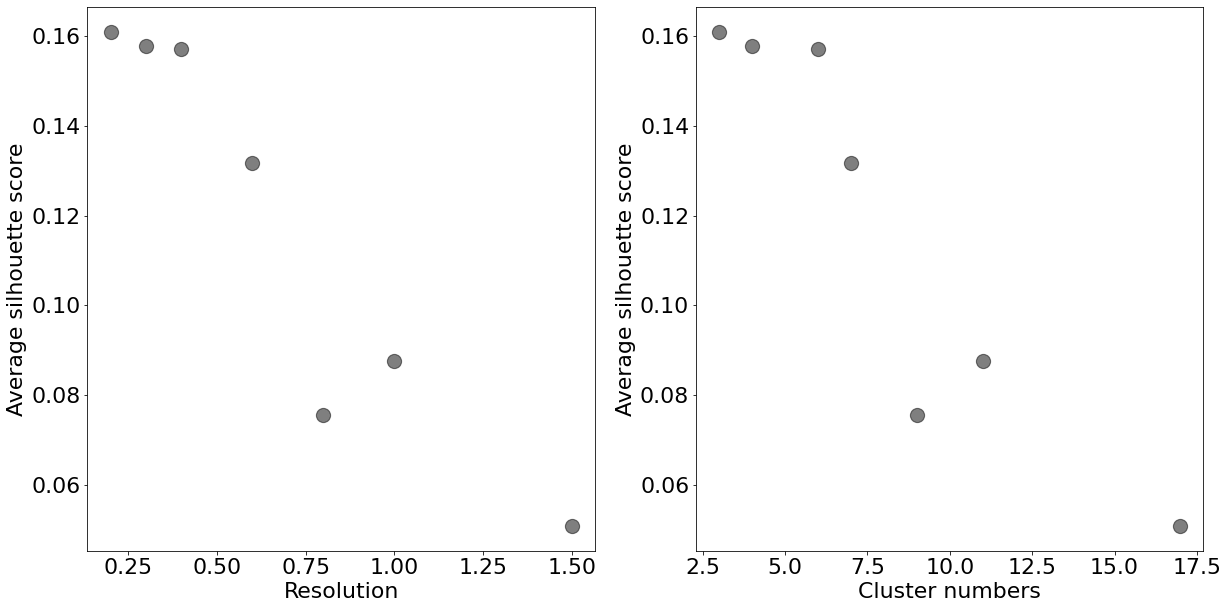

In [15]:
figpath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/B_cells/asB/'
summary_plot(info_df, figpath, 'sil_summary_asB.png')

In [16]:
#try resolution 0.4
adata_asB.obs['leiden_r0.4'] = temp_adata.obs['res_0.4']
sc.tl.umap(adata_asB)

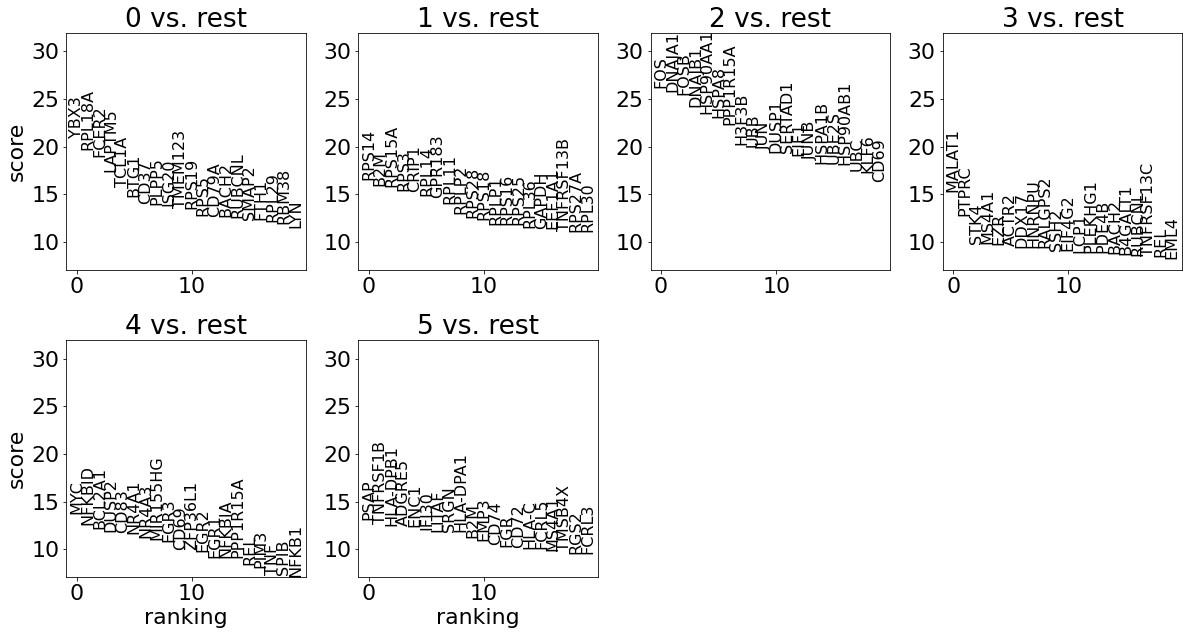

In [17]:
sc.tl.rank_genes_groups(adata_asB, groupby='leiden_r0.4', key_added='rank_genes_r0.4', 
                        use_raw = False, method = 'wilcoxon')
rcParams['figure.figsize']=(5,5)
sc.pl.rank_genes_groups(adata_asB, key='rank_genes_r0.4', fontsize=16, use_raw = False)

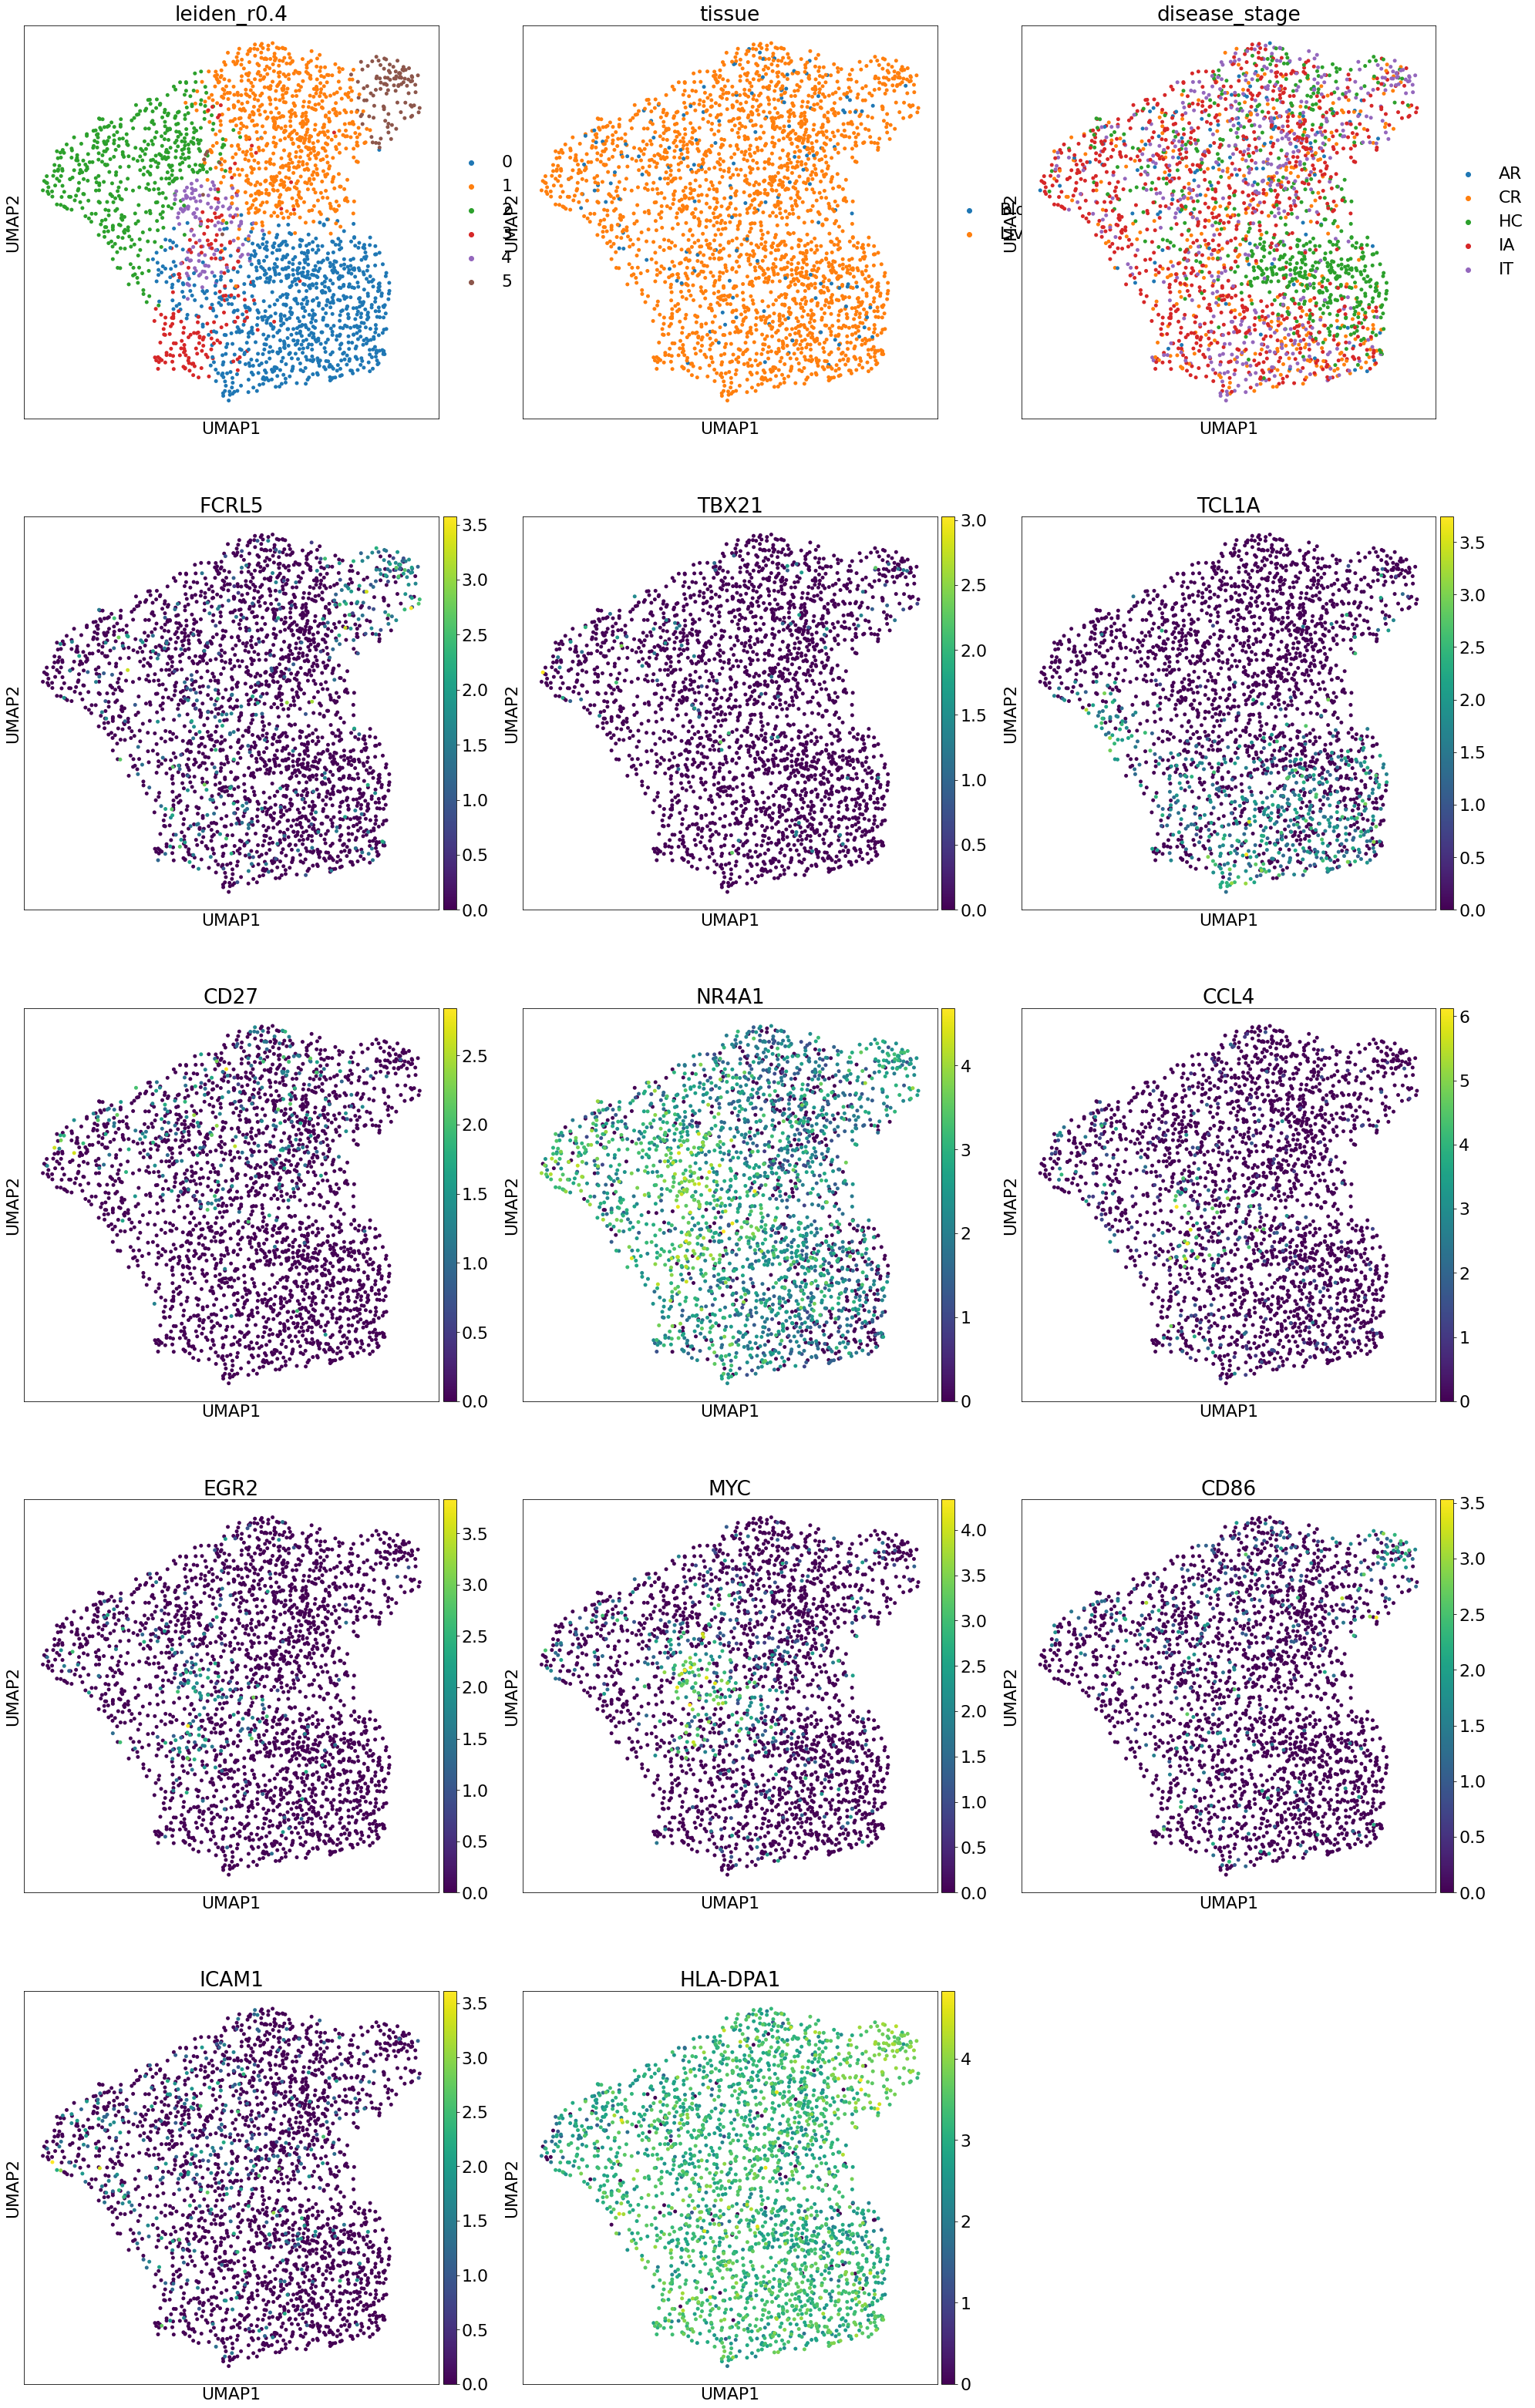

In [51]:
rcParams['figure.figsize']=(10,10)
sc.settings.figdir = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/B_cells/mB/'
sc.pl.umap(adata_asB, color=['leiden_r0.4', 'tissue', 'disease_stage',
                                'FCRL5', 'TBX21', 'TCL1A', 'CD27', 'NR4A1', 
                             'CCL4', 'EGR2', 'MYC', 'CD86', 'ICAM1', 'HLA-DPA1'], 
           s =100, ncols = 3, use_raw = False)

In [28]:
adata_asB.obs[adata_asB.obs['leiden_r0.4'] == '4'].groupby('disease_stage').size()

disease_stage
AR     6
CR    30
HC    25
IA    34
IT    23
dtype: int64

In [29]:
adata_asB.obs.groupby('disease_stage').size()

disease_stage
AR    112
CR    355
HC    606
IA    914
IT    485
dtype: int64

In [33]:
df = adata_B.obs.groupby(['disease_stage', 'patient_ID', 'subtype'], as_index = False, observed = True).size()

In [34]:
df

,disease_stage,patient_ID,subtype,size
0,IA,P190801,Antigen stimulated B,47
1,IA,P190801,Plasma,7
2,IA,P190801,Memory B,13
3,IA,P190801,doublets,16
4,IA,P191112,Antigen stimulated B,257
...,...,...,...,...
109,IT,P190402,Antigen stimulated B,202
110,IT,P190402,Plasma,49
111,IT,P190402,Memory B,35
112,IT,P190402,doublets,24


In [42]:
table = pd.pivot_table(df, values='size', index=['disease_stage', 'patient_ID'],
                    columns=['subtype'], aggfunc=np.sum, observed = True, fill_value = 0)

In [43]:
table = table.iloc[:,0:3]

In [45]:
table['total'] = table.sum(axis = 1)

In [47]:
table['asB_frac'] = table['Antigen stimulated B'] / table['total']

In [49]:
table = table.reset_index(level = [0])

In [50]:
table

subtype,disease_stage,Naive B,Memory B,Antigen stimulated B,total,asB_frac
patient_ID,,,,,,
P190801,IA,0,13,47,60,0.783333
P191112,IA,947,962,257,2166,0.118652
P191028,IA,205,535,133,873,0.152348
P190719,IA,281,360,132,773,0.170763
P190911,IA,837,551,345,1733,0.199077
P191126,CR,927,889,123,1939,0.063435
P191127,CR,2480,552,228,3260,0.069939
P191210,CR,2600,569,4,3173,0.001261
D529351,HC,250,347,41,638,0.064263
